## K-means( random initialization)

In [79]:
import numpy as np
import math

# % Standard K-means clustering
# % Inputs: data, n*d data matrix with n instances and d features
# %         K, number of clusters
# % Ouputs: labels, n*1 indicator matrix with elements from 1 to K
# %         centroids, K*d centroid matrix
# %         objV, objective function value of K-means
# % Jie TANG by 04/20/2020 jietang@brandeis.edu

def myKmeans(data, K, Maxiter=50, ObjV =math.inf, threshold = 0.01, centroids = False):
    centroids = initializeCentroid(data, K)
    for i in range(Maxiter):
        labels, New_ObjV = assign_label(data, centroids)
        centroids = update_centroid(data, K, labels)
        if ObjV-New_ObjV > threshold:
            ObjV = New_ObjV
    return labels, centroids, ObjV

## initialize k centroids randomly
def initializeCentroid(data, K):
    return data[np.random.choice(len(data), K, replace=False)]
   
## assign labels to each point
def assign_label(data, centroids):
     return np.array([np.argmin(np.sqrt(np.sum((data[i]-centroids)**2, axis=1))) for i in range(len(data))]),\
    np.sum([np.sum((data[i]-centroids)**2) for i in range(len(data))])

## update the centroids
def update_centroid(data, K, labels):
    return np.array([np.mean(data[labels==k], axis=0) for k in range(K)])

### Testing

In [76]:
## importing packages
import pandas as pd
import numpy as np
import matplotlib.pylab as plt

## loading data
three_globs = pd.read_csv('/Users/tjmask/Desktop/Semester2/DataMining/HW1/hw1/Homework_1/Datasets/three_globs.csv')
three_globs = np.array(three_globs)

In [77]:
labels, centroids, ObjV = myKmeans(three_globs, 3)

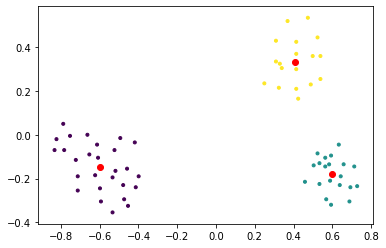

In [78]:
plt.scatter(three_globs[:, 0], three_globs[:, 1], marker='.', c = labels)
plt.scatter(centroids[:, 0], centroids[:,1], c='r')
plt.show()

## K-means++

In [229]:
import numpy as np

## K-means++ initialization 
def myKmeans_pp(data, K):
    ## get the data shape and creat an empty centriod array
    d = data.shape[1] 
    centroids = np.zeros([K,d])
    index = np.zeros(K)
    
    ## randomly choose the first centroid  
    index[0] = np.random.choice(len(data),1, replace=False)
    initial_centroid = data[int(index[0])]
    centroids[0] = initial_centroid
    
    ## choose next centroids till all centroids are chosen
    for k in range(1, K):
        
        ## calculating the distance 
        distance = np.array([(np.sum((data[i]-centroids)**2)) for i in range(len(data))])

        ## get the index of the point which has the max distance 
        index[k] = np.argmax(distance)
        
        ## update centroids
        centroids[k] = (data[int(index[k])])
    
    return centroids, index

### Testing

In [230]:
Kmeans_pp_initial, index  = myKmeans_pp(three_globs, 3)
Kmeans_pp_initial, index

(array([[ 0.6384  , -0.22943 ],
        [-0.83292 , -0.069825],
        [ 0.47382 ,  0.53367 ]]), array([59.,  9., 27.]))

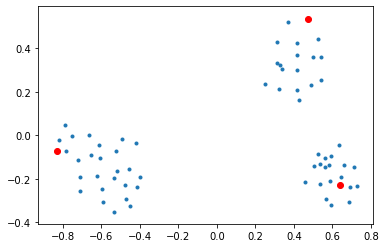

In [231]:
plt.scatter(three_globs[:, 0], three_globs[:, 1], marker='.')
plt.scatter(Kmeans_pp_initial[:, 0], Kmeans_pp_initial[:,1], c='r')
plt.show()

## Greedy K-means 

In [160]:
from sklearn.cluster import KMeans

def Greedy_Kmeans(data, K):
    
# % Standard K-means clustering
# % Inputs: data, n*d data matrix with n instances and d features;
#           K, number of clusters;     
# % Ouputs: greedy_initial, the greedy initialization k*d data matrix;      
# % Jie Tang 04/20/2020 jietang@brandeis.edu
    
    ## get the data shape and create an empty centriod array
    d = data.shape[1] 
    
    ## choose the mean of all points as the initialized centroid
    initial_centriod = np.sum(data, axis=0)
    
    centroid_k = []
    centroid_k.append(initial_centriod)
   
    for k in range(2, K+1):
        tmp_socre = np.zeros(len(data))
        tmp_centroid = []
        for i in range(len(data)):
            ## use my own K-means to select the centroids which as the lowest ObjV
            labels, centroids, ObjV = myKmeans(data, k, centroids=centroid_k[k-2])
            tmp_centroid.append(centroids)
            tmp_socre[i] = ObjV
            
        centroid_k.append(tmp_centroid[np.argmin(tmp_socre)])
        
    greedy_initial = centroid_k[k-1]
    
    return greedy_initial

### Testing

In [161]:
greedy_initial = Greedy_Kmeans(three_globs, 3)

greedy_initial

array([[ 0.60025   , -0.18082058],
       [-0.59942815, -0.14482287],
       [ 0.40953333,  0.33361   ]])

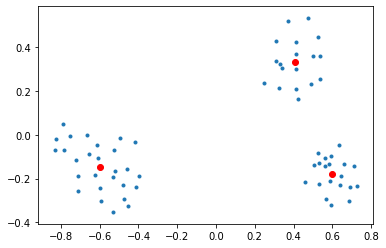

In [138]:
plt.scatter(three_globs[:, 0], three_globs[:, 1], marker='.')
plt.scatter(greedy_initial[:, 0], greedy_initial[:,1], c='r')
plt.show()

## Kernel K-means

In [243]:
from sklearn.cluster import KMeans
from utils import * 
from math import exp, inf


def myKernalKmeans(data, K, sigma):
    
# % Standard K-means clustering
# % Inputs: data, n*d data matrix with n instances and d features;
#           K, number of clusters; 
#           sigma, the variance we want the kernel to have;      
# % Ouputs: labels, n*1 indicator matrix with elements from 1 to K
# %         objV, objective function value of K-means
# % Jie Tang 04/20/2020 jietang@brandeis.edu

    maxIter = 100;
    threshold = 0.04;
    old_ObjV = inf;
    n = len(data)
    labels = np.zeros([n])
    for i in range(n):
        labels[i] = np.random.choice(K, 1, replace = True)
        
    ## generate the Kernel matrix 
    Kmatrix = kernel(data, sigma)
    
    for i in range(maxIter):
        labels, ObjV = assignLabel(data, labels,Kmatrix, n, K) ## update labels
        
        if old_ObjV-ObjV > threshold:
            old_ObjV = ObjV
    return labels, ObjV



def assignLabel(data, labels, Kmatrix, n, K):
    ObjV = 0
    distance = np.zeros([n, K]) 
    
    for i in range(n):
        for k in range(K):
            ## computing distance based on objective functions
            distance[i,k] = -2*np.sum(Kmatrix[i,np.where(labels==k)[0]])/np.sum(labels==k) +\
            np.sum(Kmatrix[np.where(labels==k)[0],np.where(labels==k)[0]])/(np.sum(labels==k)^2)
                
        value = np.min(distance[i,:])
        ObjV += value
        labels[i] = np.argmin(distance[i,:])
        
    return labels, ObjV


def squaredDistance(a, b):
    return np.linalg.norm(a-b)

def kernel(data, sigma):
    """" 
    Inputs: data, n*d data matrix with n instances and d features
            K, number of clusters; 
            #####sigma, the variance we want the kernel to have;#####
    Ouputs: Kmatrix, n*n Kernel matrix 

    """""
    nData = len(data)
    Kmatrix = np.zeros([nData,nData]) # nData x nData matrix
    
     
    # Calculate the Kmatrix matrix
    for i in range(nData):
        for j in range(i,nData):
            if i != j:  # diagonal element of matrix = 0
                
#                 ############# Polynomial Kernel ############# 
#                 # kernel: K(xi,xj) = xi*xj**2
#                 Kmatrix[i][j] = abs(data[i,0]*data[j,0]) + abs(data[i,1]*data[j,1]) 
#                 Kmatrix[j][i] = Kmatrix[i][j]
                
                
                ############## Gaussian Kernel ##############
                # kernel: K(xi,xj) = e ( (-|xi-xj|**2) / (2sigma**2)
                square_dist = squaredDistance(data[i],data[j])
                base = 2.0 * sigma**2
                Kmatrix[i][j] = exp(-square_dist/base)
                Kmatrix[j][i] = Kmatrix[i][j]

    return Kmatrix

### Testing

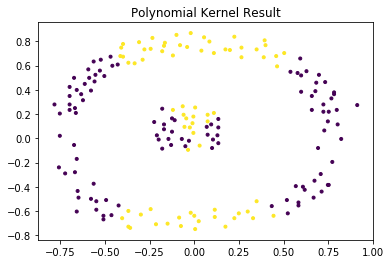

In [235]:
## loading data 
import pandas as pd
import numpy as np
import matplotlib.pylab as plt

eye  = pd.read_csv('/Users/tjmask/Desktop/Semester2/DataMining/HW1/hw1/Homework_1/Datasets/eye.csv')
eye = np.array(eye.iloc[:,1:])

labels, ObjV = myKernalKmeans(eye, 2)
plt.scatter(eye[:, 0], eye[:, 1], marker='.', c = labels)
plt.title('Polynomial Kernel Result')
plt.show()

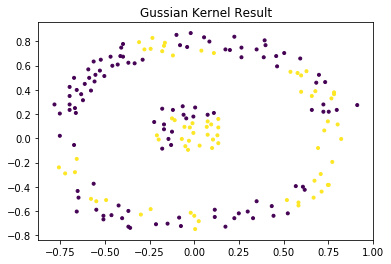

In [244]:
labels, ObjV = myKernalKmeans(eye, 2, 0.05)
plt.scatter(eye[:, 0], eye[:, 1], marker='.', c = labels)
plt.title('Gussian Kernel Result')
plt.show()

Both Gussian Kernel and Polynomial Kernel shows very bad performance. I tried different Polynomial, but they didn't work. I don't know how to fix it honestly. 